# Manejo de imágenes en TensorFlow core con tf.data
Este ejemplo muestra cómo cargar un dataset de imágenes con `tf.data`.

El dataset empleado en este ejemplo se distribuye como directorios de imágenes, con una clase de imgaen por directorio.

## Instalación

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
tf.__version__

'2.0.0'

## Obtener las imágenes
Antes de iniciar el entrenamiento es necesario un conjunto de imágenes para enseñar a la red acerca de las nuevas clases que se desea reconocer. Para ello emplearemos un conjunto de fotografías de flores con licencia de creative-commons de Google.

In [6]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 21s 0us/step


Después de la descarga (218 MB), debe haber una copia de las fotos de las flores disponible.

El directorio contiene 5 subdirectorios, uno por clase:

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [8]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

Cada directorio contiene imágenes de un tipo de flor. A continuación se muestran algunos ejemplos:

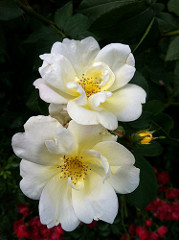

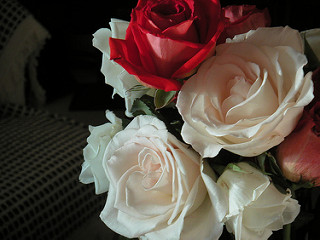

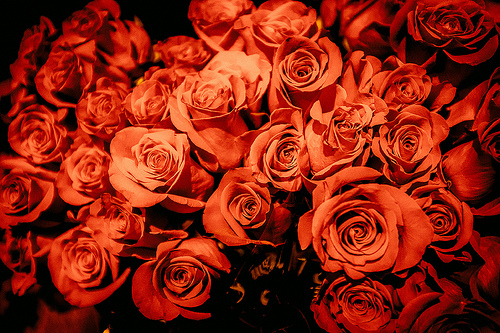

In [9]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## Cargar empleando `keras.preprocessor`
Una forma simple de cargar las imágenes es por medio de `tf.keras.preprocessing`.

In [10]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Definición de parámetros para el cargardor.

In [11]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [12]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


Inspeccionar un conjunto de imágenes.

In [14]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

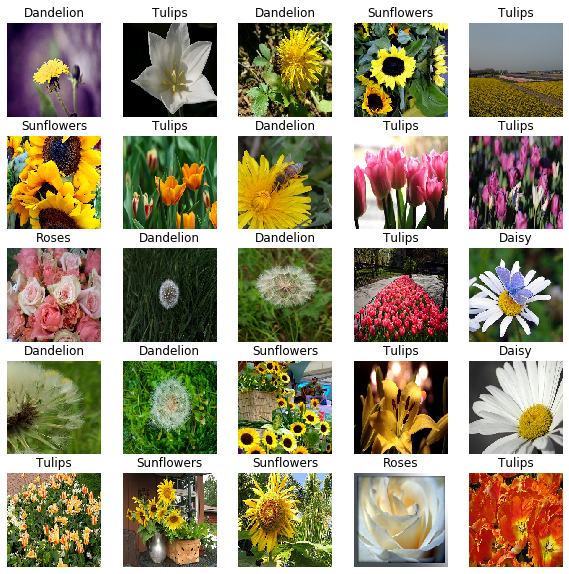

In [15]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Cargar usando `tf.data`
El método de `keras.preprocessing` tiene los siguientes inconvenientes:
- Es lento.
- Carece de control granular.
- No está bien integrado con el resto de TensorFlow.

Para cargar las imágenes como `tf.data.Dataset` primero se crea un dataset de las rutas de archivos.

In [17]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [18]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\Marciano\\.keras\\datasets\\flower_photos\\daisy\\174131220_c853df1287.jpg'
b'C:\\Users\\Marciano\\.keras\\datasets\\flower_photos\\tulips\\7002703410_3e97b29da5_n.jpg'
b'C:\\Users\\Marciano\\.keras\\datasets\\flower_photos\\daisy\\4646886118_b5c5ceaf6d_n.jpg'
b'C:\\Users\\Marciano\\.keras\\datasets\\flower_photos\\dandelion\\19622465055_2a62ebd504_m.jpg'
b'C:\\Users\\Marciano\\.keras\\datasets\\flower_photos\\sunflowers\\21349789961_18ba1af5b7_n.jpg'


Escribimos una función pura de TensorFlow que convierte las rutas de archivos en un par (datos_imagen, etiqueta).

In [19]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [20]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [21]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Empleamos `Dataset.map` para crear un dataset de pares `image, label`.

In [22]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [23]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False False False False]


## Métodos básicos de entrenamiento
Para entrenar un modelo con este dataset se requiere que los datos:
- Estén bien mezclados.
- Sean procesados por lotes.
- Los lotes estén disponibles tan pronto sea posible.

Estas características pueden ser fácilmente añadidas por medio del api `tf.data`.

In [24]:


def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [25]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

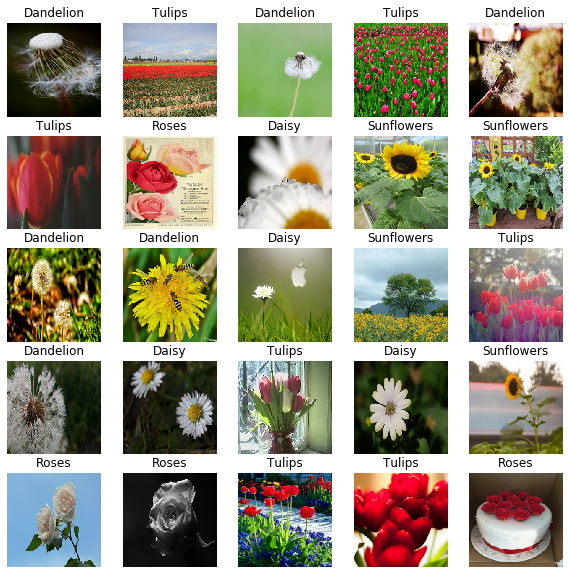

In [26]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Desempeño
Para investigar primero definimos una función para verificar el desempeño de nuestros datasets.

In [27]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

Comparamos la velocidad de los dos generadores de datasets:

In [28]:
# `keras.preprocessing`
timeit(train_data_gen)

....................................................................................................
1000 batches: 107.13033056259155 s
298.70159 Images/s


In [29]:
# `tf.data`
timeit(train_ds)

....................................................................................................
1000 batches: 63.110440492630005 s
507.04764 Images/s


Una gran parte de la ganancia en desempeño es por el uso de `.cache`.

In [30]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

....................................................................................................
1000 batches: 121.63814210891724 s
263.07538 Images/s


Si el dataset no cabe en memoria  se emplea un archivo de cache para mantener algunas de las ventajas.

In [32]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

....................................................................................................
1000 batches: 149.73358368873596 s
213.71291 Images/s
